# Compare NAMOC index

Author: Ziqi Yin

Last modified: 2024 Feb 16

Table of contents:
* [Time series of NAMOC index, freshwater flux, and annual mean sea ice extent bounded by March (max) and September (min) values](#first-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import scipy.signal as sig #for filtering

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import geocat.comp as gc #to interpolate and extrapolate data from hybrid-sigma levels to isobaric levels

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
#import xesmf as xe

In [2]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

## 1. NAMOC index series <a class="anchor" id="first-bullet"></a>

### Read data (cdo cannot handle 5-d variable MOC)

#### F09M

In [7]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_MOC_monthly_p1 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.pop.h.MOC.000101-005012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_1pctCO2_MOC_monthly_p2 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.pop.h.MOC.005101-010012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_1pctCO2_MOC_monthly_p3 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.pop.h.MOC.010101-015012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_1pctCO2_MOC_monthly = xr.concat([f09_1pctCO2_MOC_monthly_p1, f09_1pctCO2_MOC_monthly_p2, f09_1pctCO2_MOC_monthly_p3], dim='time')[:1680,:,:]

# 4xext
f09_4xext_MOC_monthly_p1 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.pop.h.MOC.014101-019012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_4xext_MOC_monthly_p2 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.pop.h.MOC.019101-024012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_4xext_MOC_monthly_p3 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.pop.h.MOC.024101-029012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_4xext_MOC_monthly_p4 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.pop.h.MOC.029101-034012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_4xext_MOC_monthly_p5 = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/ocn/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.pop.h.MOC.034101-035012.nc')['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000))
f09_4xext_MOC_monthly = xr.concat([f09_4xext_MOC_monthly_p1, f09_4xext_MOC_monthly_p2, f09_4xext_MOC_monthly_p3, f09_4xext_MOC_monthly_p4, f09_4xext_MOC_monthly_p5], dim='time')[:,:,:]

f09_1pctCO2_4xext_MOC_monthly = xr.concat([f09_1pctCO2_MOC_monthly, f09_4xext_MOC_monthly], dim='time')

In [30]:
moc_z = f09_1pctCO2_4xext_MOC_yearly.moc_z.values
lat_aux_grid = f09_1pctCO2_4xext_MOC_yearly.lat_aux_grid.values
time_piControl = pd.date_range('1801-01-01', periods=100*12, freq='M')
time_1pctCO2 = pd.date_range('1901-01-01', periods=140*12, freq='M')
time_4xext = pd.date_range('2041-01-01', periods=210*12, freq='M')
time_1pctCO2_4xext = pd.date_range('1901-01-01', periods=350*12, freq='M')

In [32]:
# Save as netcdf file
df = xr.DataArray(f09_1pctCO2_4xext_MOC_monthly, dims=['time', 'moc_z', 'lat_aux_grid'], coords=[('time', time_1pctCO2_4xext),('moc_z', moc_z),('lat_aux_grid', lat_aux_grid)], name='MOC', attrs=dict(longname='Meridional Overturning Circulation', units='Sv'))
df.to_netcdf(home_dir+'dynamic_GrIS/f09muntjewerf/f09_MOC_1pctCO2_4xext_monthly.nc')

In [33]:
f09_1pctCO2_4xext_MOC_monthly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_MOC_1pctCO2_4xext_monthly.nc')['MOC']

# Calculate yearly average
f09_1pctCO2_4xext_MOC_yearly = weighted_temporal_mean(f09_1pctCO2_4xext_MOC_monthly)

# Find NAMOC index
f09_1pctCO2_4xext_NAMOC_yearly = f09_1pctCO2_4xext_MOC_yearly.max(dim=['moc_z','lat_aux_grid'])

#### F09

In [35]:
f09_nohacks_1pctCO2_MOC_monthly = np.zeros((140*12,28,117))

for i in range(1,141):
    for j in range(1,13):
        filename='/glade/campaign/cesm/development/amwg/aherring/release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0/ocn/hist/release-cesm2.1.3.cism_B1850G1PCT_f09_g17_2160pes_230303_test0.pop.h.'+str(i).zfill(4)+'-'+str(j).zfill(2)+'.nc'
        f09_nohacks_1pctCO2_MOC_monthly[(i-1)*12+j-1,:,:] = xr.open_dataset(filename)['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000)).values 

# Save as netcdf file
df = xr.DataArray(f09_nohacks_1pctCO2_MOC_monthly, dims=['time', 'moc_z', 'lat_aux_grid'], coords=[('time', time_1pctCO2),('moc_z', moc_z),('lat_aux_grid', lat_aux_grid)], name='MOC', attrs=dict(longname='Meridional Overturning Circulation', units='Sv'))
df.to_netcdf(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_MOC_1pctCO2_monthly.nc')

In [36]:
f09_nohacks_4xext_MOC_monthly = np.zeros((210*12,28,117))

for i in range(1,211):
    for j in range(1,13):
        filename='/glade/campaign/cesm/development/amwg/aherring/release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324/ocn/hist/release-cesm2.1.3.cism_B1850G4XCO2_f09_g17_2160pes_230324.pop.h.'+str(i).zfill(4)+'-'+str(j).zfill(2)+'.nc'
        f09_nohacks_4xext_MOC_monthly[(i-1)*12+j-1,:,:] = xr.open_dataset(filename)['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000)).values 

# Save as netcdf file
df = xr.DataArray(f09_nohacks_4xext_MOC_monthly, dims=['time', 'moc_z', 'lat_aux_grid'], coords=[('time', time_4xext),('moc_z', moc_z),('lat_aux_grid', lat_aux_grid)], name='MOC', attrs=dict(longname='Meridional Overturning Circulation', units='Sv'))
df.to_netcdf(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_MOC_4xext_monthly.nc')

In [4]:
f09_nohacks_1pctCO2_MOC_monthly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_MOC_1pctCO2_monthly.nc')['MOC']
f09_nohacks_4xext_MOC_monthly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_MOC_4xext_monthly.nc')['MOC']
f09_nohacks_1pctCO2_4xext_MOC_monthly = xr.concat([f09_nohacks_1pctCO2_MOC_monthly, f09_nohacks_4xext_MOC_monthly], dim='time')

# Calculate yearly average
f09_nohacks_1pctCO2_4xext_MOC_yearly = weighted_temporal_mean(f09_nohacks_1pctCO2_4xext_MOC_monthly)

# Find NAMOC index
f09_nohacks_1pctCO2_4xext_NAMOC_yearly = f09_nohacks_1pctCO2_4xext_MOC_yearly.max(dim=['moc_z','lat_aux_grid'])

#### ARCTIC

In [51]:
ARCTIC_1pctCO2_MOC_monthly = np.zeros((140*12,28,117))

for i in range(1,141):
    for j in range(1,13):
        filename='/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/ocn/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.pop.h.'+str(i).zfill(4)+'-'+str(j).zfill(2)+'.nc'
        ARCTIC_1pctCO2_MOC_monthly[(i-1)*12+j-1,:,:] = xr.open_dataset(filename)['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000)).values 

# Save as netcdf file
df = xr.DataArray(ARCTIC_1pctCO2_MOC_monthly, dims=['time', 'moc_z', 'lat_aux_grid'], coords=[('time', time_1pctCO2),('moc_z', moc_z),('lat_aux_grid', lat_aux_grid)], name='MOC', attrs=dict(longname='Meridional Overturning Circulation', units='Sv'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_MOC_1pctCO2_monthly.nc')

In [ ]:
ARCTIC_4xext_MOC_monthly = np.zeros((210*12,28,117))

for i in range(1,211):
    for j in range(1,13):
        filename='/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001/ocn/hist/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.pop.h.'+str(i).zfill(4)+'-'+str(j).zfill(2)+'.nc'
        ARCTIC_4xext_MOC_monthly[(i-1)*12+j-1,:,:] = xr.open_dataset(filename)['MOC'][:,1,0,:,:].sel(lat_aux_grid=slice(28,90)).sel(moc_z=slice(50000,1000000)).values 

# Save as netcdf file
df = xr.DataArray(ARCTIC_4xext_MOC_monthly, dims=['time', 'moc_z', 'lat_aux_grid'], coords=[('time', time_4xext),('moc_z', moc_z),('lat_aux_grid', lat_aux_grid)], name='MOC', attrs=dict(longname='Meridional Overturning Circulation', units='Sv'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_MOC_4xext_monthly.nc')

In [5]:
ARCTIC_1pctCO2_MOC_monthly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_MOC_1pctCO2_monthly.nc')['MOC']
ARCTIC_4xext_MOC_monthly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_MOC_4xext_monthly.nc')['MOC']
ARCTIC_1pctCO2_4xext_MOC_monthly = xr.concat([ARCTIC_1pctCO2_MOC_monthly, ARCTIC_4xext_MOC_monthly], dim='time')

# Calculate yearly average
ARCTIC_1pctCO2_4xext_MOC_yearly = weighted_temporal_mean(ARCTIC_1pctCO2_4xext_MOC_monthly)

# Find NAMOC index
ARCTIC_1pctCO2_4xext_NAMOC_yearly = ARCTIC_1pctCO2_4xext_MOC_yearly.max(dim=['moc_z','lat_aux_grid'])

### Read data (MB, SMB)

In [11]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:140]
f09_int_1pctCO2_id = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.total_calving_flux_tavg.0001-0161.nc')['total_calving_flux_tavg'][1:141]
f09_int_1pctCO2_bmb = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.total_bmb_flux_tavg.0001-0161.nc')['total_bmb_flux_tavg'][1:141]

# 4xCO2
f09_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QRUNOFF_4xext_yearly.nc')['QRUNOFF']
f09_int_4xext_id = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_total_calving_flux_tavg_4xext.nc')['total_calving_flux_tavg']
f09_int_4xext_bmb = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_total_bmb_flux_tavg_4xext.nc')['total_bmb_flux_tavg']

In [12]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:]
f09_nohacks_int_1pctCO2_id = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_total_calving_flux_1pctCO2.nc')['total_calving_flux']
f09_nohacks_int_1pctCO2_bmb = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_total_bmb_flux_1pctCO2.nc')['total_bmb_flux']

# 4xext
f09_nohacks_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QRUNOFF_4xext_yearly.nc')['QRUNOFF'][:]
f09_nohacks_int_4xext_id = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_total_calving_flux_4xext.nc')['total_calving_flux']
f09_nohacks_int_4xext_bmb = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_total_bmb_flux_4xext.nc')['total_bmb_flux']

In [13]:
## Arctic grid
# 1pctCO2
ARCTIC_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF']
ARCTIC_int_1pctCO2_id = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_total_calving_flux_1pctCO2.nc')['total_calving_flux']
ARCTIC_int_1pctCO2_bmb = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_total_bmb_flux_1pctCO2.nc')['total_bmb_flux']

# 4xext
ARCTIC_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_4xext_yearly.nc')['QRUNOFF']
ARCTIC_int_4xext_id = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_total_calving_flux_4xext.nc')['total_calving_flux']
ARCTIC_int_4xext_bmb = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_total_bmb_flux_4xext.nc')['total_bmb_flux']

In [14]:
## Area and land fraction
Re = 6371.22 * 1e3 #[m]

f09_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file1)['area'] #[Radian2]
f09_area = f09_area.values * Re**2

f09_mask_file2 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file2)['landfrac'] #fraction of grid cell that is active

ARCTIC_mask_file1 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file1)['area'] #[Radian2]
ARCTIC_area = ARCTIC_area.values * Re**2

ARCTIC_mask_file2 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file2)['landfrac']

In [15]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

### Read data (sea ice concentration, thickness)

In [16]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_aice_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_1pctCO2_yearly.nc')['aice'][:140]
f09_1pctCO2_aice_Mar = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_1pctCO2_Mar.nc')['aice'][:140]
f09_1pctCO2_aice_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_1pctCO2_Apr.nc')['aice'][:140]
f09_1pctCO2_aice_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_1pctCO2_Sep.nc')['aice'][:140]
f09_1pctCO2_hi_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_hi_1pctCO2_yearly.nc')['hi'][:140]
f09_1pctCO2_hi_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_hi_1pctCO2_Apr.nc')['hi'][:140]
f09_1pctCO2_hi_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_hi_1pctCO2_Sep.nc')['hi'][:140]

# 4xCO2
f09_4xext_aice_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_4xext_yearly.nc')['aice']
f09_4xext_aice_Mar = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_4xext_Mar.nc')['aice']
f09_4xext_aice_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_4xext_Apr.nc')['aice']
f09_4xext_aice_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_aice_4xext_Sep.nc')['aice']
f09_4xext_hi_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_hi_4xext_yearly.nc')['hi']
f09_4xext_hi_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_hi_4xext_Apr.nc')['hi']
f09_4xext_hi_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_hi_4xext_Sep.nc')['hi']

# Combine
f09_1pctCO2_4xext_aice_yearly = xr.concat([f09_1pctCO2_aice_yearly, f09_4xext_aice_yearly], dim='time')
f09_1pctCO2_4xext_aice_Mar = xr.concat([f09_1pctCO2_aice_Mar, f09_4xext_aice_Mar], dim='time')
f09_1pctCO2_4xext_aice_Apr = xr.concat([f09_1pctCO2_aice_Apr, f09_4xext_aice_Apr], dim='time')
f09_1pctCO2_4xext_aice_Sep = xr.concat([f09_1pctCO2_aice_Sep, f09_4xext_aice_Sep], dim='time')
f09_1pctCO2_4xext_hi_yearly = xr.concat([f09_1pctCO2_hi_yearly, f09_4xext_hi_yearly], dim='time')
f09_1pctCO2_4xext_hi_Apr = xr.concat([f09_1pctCO2_hi_Apr, f09_4xext_hi_Apr], dim='time')
f09_1pctCO2_4xext_hi_Sep = xr.concat([f09_1pctCO2_hi_Sep, f09_4xext_hi_Sep], dim='time')

In [17]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_aice_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_1pctCO2_yearly.nc')['aice']
f09_nohacks_1pctCO2_aice_Mar = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_1pctCO2_Mar.nc')['aice']
f09_nohacks_1pctCO2_aice_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_1pctCO2_Apr.nc')['aice']
f09_nohacks_1pctCO2_aice_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_1pctCO2_Sep.nc')['aice']
f09_nohacks_1pctCO2_hi_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_hi_1pctCO2_yearly.nc')['hi']
f09_nohacks_1pctCO2_hi_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_hi_1pctCO2_Apr.nc')['hi']
f09_nohacks_1pctCO2_hi_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_hi_1pctCO2_Sep.nc')['hi']

# 4xext
f09_nohacks_4xext_aice_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_4xext_yearly.nc')['aice']
f09_nohacks_4xext_aice_Mar = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_4xext_Mar.nc')['aice']
f09_nohacks_4xext_aice_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_4xext_Apr.nc')['aice']
f09_nohacks_4xext_aice_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_aice_4xext_Sep.nc')['aice']
f09_nohacks_4xext_hi_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_hi_4xext_yearly.nc')['hi']
f09_nohacks_4xext_hi_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_hi_4xext_Apr.nc')['hi']
f09_nohacks_4xext_hi_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_hi_4xext_Sep.nc')['hi']

# Combine
f09_nohacks_1pctCO2_4xext_aice_yearly = xr.concat([f09_nohacks_1pctCO2_aice_yearly, f09_nohacks_4xext_aice_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_aice_Mar = xr.concat([f09_nohacks_1pctCO2_aice_Mar, f09_nohacks_4xext_aice_Mar], dim='time')
f09_nohacks_1pctCO2_4xext_aice_Apr = xr.concat([f09_nohacks_1pctCO2_aice_Apr, f09_nohacks_4xext_aice_Apr], dim='time')
f09_nohacks_1pctCO2_4xext_aice_Sep = xr.concat([f09_nohacks_1pctCO2_aice_Sep, f09_nohacks_4xext_aice_Sep], dim='time')
f09_nohacks_1pctCO2_4xext_hi_yearly = xr.concat([f09_nohacks_1pctCO2_hi_yearly, f09_nohacks_4xext_hi_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_hi_Apr = xr.concat([f09_nohacks_1pctCO2_hi_Apr, f09_nohacks_4xext_hi_Apr], dim='time')
f09_nohacks_1pctCO2_4xext_hi_Sep = xr.concat([f09_nohacks_1pctCO2_hi_Sep, f09_nohacks_4xext_hi_Sep], dim='time')

In [18]:
## ARCTIC
# 1pctCO2
ARCTIC_1pctCO2_aice_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_1pctCO2_yearly.nc')['aice']
ARCTIC_1pctCO2_aice_Mar = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_1pctCO2_Mar.nc')['aice']
ARCTIC_1pctCO2_aice_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_1pctCO2_Apr.nc')['aice']
ARCTIC_1pctCO2_aice_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_1pctCO2_Sep.nc')['aice']
ARCTIC_1pctCO2_hi_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_hi_1pctCO2_yearly.nc')['hi']
ARCTIC_1pctCO2_hi_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_hi_1pctCO2_Apr.nc')['hi']
ARCTIC_1pctCO2_hi_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_hi_1pctCO2_Sep.nc')['hi']

# 4xext
ARCTIC_4xext_aice_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_4xext_yearly.nc')['aice']
ARCTIC_4xext_aice_Mar = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_4xext_Mar.nc')['aice']
ARCTIC_4xext_aice_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_4xext_Apr.nc')['aice']
ARCTIC_4xext_aice_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_aice_4xext_Sep.nc')['aice']
ARCTIC_4xext_hi_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_hi_4xext_yearly.nc')['hi']
ARCTIC_4xext_hi_Apr = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_hi_4xext_Apr.nc')['hi']
ARCTIC_4xext_hi_Sep = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_hi_4xext_Sep.nc')['hi']

# Combine
ARCTIC_1pctCO2_4xext_aice_yearly = xr.concat([ARCTIC_1pctCO2_aice_yearly, ARCTIC_4xext_aice_yearly], dim='time')
ARCTIC_1pctCO2_4xext_aice_Mar = xr.concat([ARCTIC_1pctCO2_aice_Mar, ARCTIC_4xext_aice_Mar], dim='time')
ARCTIC_1pctCO2_4xext_aice_Apr = xr.concat([ARCTIC_1pctCO2_aice_Apr, ARCTIC_4xext_aice_Apr], dim='time')
ARCTIC_1pctCO2_4xext_aice_Sep = xr.concat([ARCTIC_1pctCO2_aice_Sep, ARCTIC_4xext_aice_Sep], dim='time')
ARCTIC_1pctCO2_4xext_hi_yearly = xr.concat([ARCTIC_1pctCO2_hi_yearly, ARCTIC_4xext_hi_yearly], dim='time')
ARCTIC_1pctCO2_4xext_hi_Apr = xr.concat([ARCTIC_1pctCO2_hi_Apr, ARCTIC_4xext_hi_Apr], dim='time')
ARCTIC_1pctCO2_4xext_hi_Sep = xr.concat([ARCTIC_1pctCO2_hi_Sep, ARCTIC_4xext_hi_Sep], dim='time')

In [19]:
tarea = xr.open_dataset('/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001/ice/hist/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.cice.h.0001-01.nc')['tarea']
TLAT = xr.open_dataset('/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001/ice/hist/cesm2_2_alpha06d.poparctic_B1850G4XCO2_ne0ARCTICne30x4_g17_8192pes_221021_Nx2yrs.001.cice.h.0001-01.nc')['TLAT']

### Calculate

In [20]:
## Concat
f09_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_1pctCO2_QRUNOFF_yearly, f09_4xext_QRUNOFF_yearly], dim='time')
f09_int_1pctCO2_4xext_id = xr.concat([f09_int_1pctCO2_id, f09_int_4xext_id], dim='time')
f09_int_1pctCO2_4xext_bmb = xr.concat([f09_int_1pctCO2_bmb, f09_int_4xext_bmb], dim='time')

f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_nohacks_1pctCO2_QRUNOFF_yearly, f09_nohacks_4xext_QRUNOFF_yearly], dim='time')
f09_nohacks_int_1pctCO2_4xext_id = xr.concat([f09_nohacks_int_1pctCO2_id, f09_nohacks_int_4xext_id], dim='time')
f09_nohacks_int_1pctCO2_4xext_bmb = xr.concat([f09_nohacks_int_1pctCO2_bmb, f09_nohacks_int_4xext_bmb], dim='time')

ARCTIC_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([ARCTIC_1pctCO2_QRUNOFF_yearly, ARCTIC_4xext_QRUNOFF_yearly], dim='time')
ARCTIC_int_1pctCO2_4xext_id = xr.concat([ARCTIC_int_1pctCO2_id, ARCTIC_int_4xext_id], dim='time')
ARCTIC_int_1pctCO2_4xext_bmb = xr.concat([ARCTIC_int_1pctCO2_bmb, ARCTIC_int_4xext_bmb], dim='time')

In [21]:
## Integrate over the GrIS
# F09M
f09_int_1pctCO2_4xext_QRUNOFF = (f09_1pctCO2_4xext_QRUNOFF_yearly * f09_GrIS_mask * f09_area).sum(dim=['lat','lon'])/(1e3*1e3)
f09_int_1pctCO2_4xext_id =  -f09_int_1pctCO2_4xext_id/(1e3*1e3)
f09_int_1pctCO2_4xext_bmb =  -f09_int_1pctCO2_4xext_bmb/(1e3*1e3)

#F09
f09_nohacks_int_1pctCO2_4xext_QRUNOFF = (f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly * f09_nohacks_GrIS_mask * f09_area).sum(dim=['lat','lon'])/(1e3*1e3)
f09_nohacks_int_1pctCO2_4xext_id =  -f09_nohacks_int_1pctCO2_4xext_id/(1e3*1e3)
f09_nohacks_int_1pctCO2_4xext_bmb =  -f09_nohacks_int_1pctCO2_4xext_bmb/(1e3*1e3)

#ARCTIC
ARCTIC_int_1pctCO2_4xext_QRUNOFF = (ARCTIC_1pctCO2_4xext_QRUNOFF_yearly * ARCTIC_GrIS_mask * ARCTIC_area).sum(dim=['lndgrid'])/(1e3*1e3)
ARCTIC_int_1pctCO2_4xext_id =  -ARCTIC_int_1pctCO2_4xext_id/(1e3*1e3)
ARCTIC_int_1pctCO2_4xext_bmb =  -ARCTIC_int_1pctCO2_4xext_bmb/(1e3*1e3)

In [22]:
## Calculate freshwater flux (runoff+calving)
# F09M
f09_int_1pctCO2_4xext_ff = f09_int_1pctCO2_4xext_QRUNOFF + f09_int_1pctCO2_4xext_id.values + f09_int_1pctCO2_4xext_bmb.values

#F09
f09_nohacks_int_1pctCO2_4xext_ff = f09_nohacks_int_1pctCO2_4xext_QRUNOFF + f09_nohacks_int_1pctCO2_4xext_id.values + f09_nohacks_int_1pctCO2_4xext_bmb.values

#ARCTIC
ARCTIC_int_1pctCO2_4xext_ff = ARCTIC_int_1pctCO2_4xext_QRUNOFF + ARCTIC_int_1pctCO2_4xext_id.values + ARCTIC_int_1pctCO2_4xext_bmb.values

In [23]:
## Calculate running mean
f09_int_1pctCO2_4xext_ff_rm = xr.DataArray(f09_int_1pctCO2_4xext_ff).rolling(time=20, center=True, min_periods=2).mean()

f09_nohacks_int_1pctCO2_4xext_ff_rm = f09_nohacks_int_1pctCO2_4xext_ff.rolling(time=20, center=True, min_periods=2).mean()

ARCTIC_int_1pctCO2_4xext_ff_rm = ARCTIC_int_1pctCO2_4xext_ff.rolling(time=20, center=True, min_periods=2).mean()

In [24]:
## Sea ice extent
f09_1pctCO2_4xext_iceext_yearly = tarea.where(f09_1pctCO2_4xext_aice_yearly >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12 #[10^6 km^2]
f09_1pctCO2_4xext_iceext_Mar = tarea.where(f09_1pctCO2_4xext_aice_Mar >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12 
f09_1pctCO2_4xext_iceext_Sep = tarea.where(f09_1pctCO2_4xext_aice_Sep >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12 

f09_nohacks_1pctCO2_4xext_iceext_yearly = tarea.where(f09_nohacks_1pctCO2_4xext_aice_yearly >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12 #[10^6 km^2]
f09_nohacks_1pctCO2_4xext_iceext_Mar = tarea.where(f09_nohacks_1pctCO2_4xext_aice_Mar >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12 
f09_nohacks_1pctCO2_4xext_iceext_Sep = tarea.where(f09_nohacks_1pctCO2_4xext_aice_Sep >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12 

ARCTIC_1pctCO2_4xext_iceext_yearly = tarea.where(ARCTIC_1pctCO2_4xext_aice_yearly >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12 #[10^6 km^2]
ARCTIC_1pctCO2_4xext_iceext_Mar = tarea.where(ARCTIC_1pctCO2_4xext_aice_Mar >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12
ARCTIC_1pctCO2_4xext_iceext_Sep = tarea.where(ARCTIC_1pctCO2_4xext_aice_Sep >= 0.15).where(TLAT>0).sum(dim=['ni', 'nj']) /1e12

In [25]:
## Mean Arctic sea ice thickness
f09_mean_1pctCO2_4xext_hi_yearly_NH = (f09_1pctCO2_4xext_hi_yearly.where(f09_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (f09_1pctCO2_4xext_aice_yearly.where(f09_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) #[m]
f09_mean_1pctCO2_4xext_hi_Apr_NH = (f09_1pctCO2_4xext_hi_Apr.where(f09_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (f09_1pctCO2_4xext_aice_Apr.where(f09_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) #[m]
f09_mean_1pctCO2_4xext_hi_Sep_NH = (f09_1pctCO2_4xext_hi_Sep.where(f09_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (f09_1pctCO2_4xext_aice_Sep.where(f09_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) #[m]

f09_nohacks_mean_1pctCO2_4xext_hi_yearly_NH = (f09_nohacks_1pctCO2_4xext_hi_yearly.where(f09_nohacks_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (f09_nohacks_1pctCO2_4xext_aice_yearly.where(f09_nohacks_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])
f09_nohacks_mean_1pctCO2_4xext_hi_Apr_NH = (f09_nohacks_1pctCO2_4xext_hi_Apr.where(f09_nohacks_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (f09_nohacks_1pctCO2_4xext_aice_Apr.where(f09_nohacks_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])
f09_nohacks_mean_1pctCO2_4xext_hi_Sep_NH = (f09_nohacks_1pctCO2_4xext_hi_Sep.where(f09_nohacks_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (f09_nohacks_1pctCO2_4xext_aice_Sep.where(f09_nohacks_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])

ARCTIC_mean_1pctCO2_4xext_hi_yearly_NH = (ARCTIC_1pctCO2_4xext_hi_yearly.where(ARCTIC_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (ARCTIC_1pctCO2_4xext_aice_yearly.where(ARCTIC_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])
ARCTIC_mean_1pctCO2_4xext_hi_Apr_NH = (ARCTIC_1pctCO2_4xext_hi_Apr.where(ARCTIC_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (ARCTIC_1pctCO2_4xext_aice_Apr.where(ARCTIC_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])
ARCTIC_mean_1pctCO2_4xext_hi_Sep_NH = (ARCTIC_1pctCO2_4xext_hi_Sep.where(ARCTIC_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) / (ARCTIC_1pctCO2_4xext_aice_Sep.where(ARCTIC_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])

In [26]:
## Arctic sea ice volume
f09_1pctCO2_4xext_ivol_yearly_NH = (f09_1pctCO2_4xext_hi_yearly.where(f09_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) #[m3]
f09_1pctCO2_4xext_ivol_Apr_NH = (f09_1pctCO2_4xext_hi_Apr.where(f09_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) 
f09_1pctCO2_4xext_ivol_Sep_NH = (f09_1pctCO2_4xext_hi_Sep.where(f09_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])

f09_nohacks_1pctCO2_4xext_ivol_yearly_NH = (f09_nohacks_1pctCO2_4xext_hi_yearly.where(f09_nohacks_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])
f09_nohacks_1pctCO2_4xext_ivol_Apr_NH = (f09_nohacks_1pctCO2_4xext_hi_Apr.where(f09_nohacks_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) 
f09_nohacks_1pctCO2_4xext_ivol_Sep_NH = (f09_nohacks_1pctCO2_4xext_hi_Sep.where(f09_nohacks_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) 

ARCTIC_1pctCO2_4xext_ivol_yearly_NH = (ARCTIC_1pctCO2_4xext_hi_yearly.where(ARCTIC_1pctCO2_4xext_hi_yearly >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) 
ARCTIC_1pctCO2_4xext_ivol_Apr_NH = (ARCTIC_1pctCO2_4xext_hi_Apr.where(ARCTIC_1pctCO2_4xext_hi_Apr >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj'])
ARCTIC_1pctCO2_4xext_ivol_Sep_NH = (ARCTIC_1pctCO2_4xext_hi_Sep.where(ARCTIC_1pctCO2_4xext_hi_Sep >0).where(TLAT>0) * tarea).sum(dim=['ni', 'nj']) 

### Plot

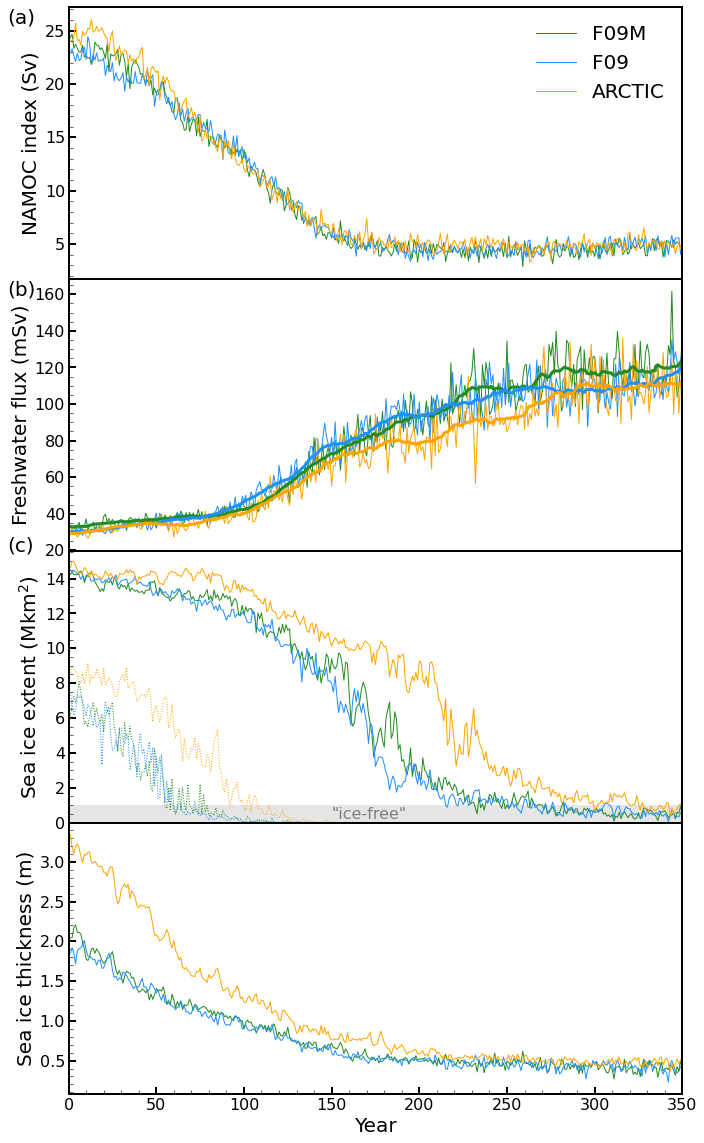

In [27]:
fig = plt.figure(figsize = (11,20))
gs=GridSpec(20,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 20
size_text = 18

#-------------------------------------------- NAMOC --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:11])

ax1.plot(np.arange(1,351), f09_1pctCO2_4xext_NAMOC_yearly, color = 'forestgreen', linewidth = 1, label='F09M');
ax1.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_NAMOC_yearly, color = 'dodgerblue', linewidth = 1, label='F09');
ax1.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_NAMOC_yearly, color = 'orange', linewidth = 1, label='ARCTIC');

ax1.text(-35, 25.7, '(a)', fontsize=size_label)

ax1.set_xlim([0, 350])
ax1.set_ylabel('NAMOC index (Sv)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
ax1.axes.get_xaxis().set_visible(False)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- Freshwater flux --------------------------------------------
ax2 = plt.subplot(gs[5:10,0:11])

ax2.plot(np.arange(1,351), f09_int_1pctCO2_4xext_ff, color = 'forestgreen', linewidth = 1);
ax2.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_ff, color = 'dodgerblue', linewidth = 1);
ax2.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_ff, color = 'orange', linewidth = 1);

ax2.plot(np.arange(1,351), f09_int_1pctCO2_4xext_ff_rm, color = 'forestgreen', linewidth = 3);
ax2.plot(np.arange(1,351), f09_nohacks_int_1pctCO2_4xext_ff_rm, color = 'dodgerblue', linewidth = 3);
ax2.plot(np.arange(1,351), ARCTIC_int_1pctCO2_4xext_ff_rm, color = 'orange', linewidth = 3);

ax2.text(-35, 159.2, '(b)', fontsize=size_label)

ax2.set_xlim([0, 350])
ax2.set_ylabel('Freshwater flux (mSv)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
ax2.axes.get_xaxis().set_visible(False)

#-------------------------------------------- Sea ice extent --------------------------------------------
ax3 = plt.subplot(gs[10:15,0:11])

ax3.fill_between(np.arange(0,351), 0, 1, facecolor='gray', alpha=0.2)
ax3.plot(np.arange(1,351), f09_1pctCO2_4xext_iceext_Sep, color='forestgreen', linewidth = 1, linestyle=':')
ax3.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_iceext_Sep, color='dodgerblue', linewidth = 1, linestyle=':')
ax3.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_iceext_Sep, color='orange', linewidth = 1, linestyle=':')

ax3.plot(np.arange(1,351), f09_1pctCO2_4xext_iceext_yearly, color='forestgreen', linewidth = 1, label='F09M')
ax3.plot(np.arange(1,351), f09_nohacks_1pctCO2_4xext_iceext_yearly, color='dodgerblue', linewidth = 1, label='F09')
ax3.plot(np.arange(1,351), ARCTIC_1pctCO2_4xext_iceext_yearly, color='orange', linewidth = 1, label='ARCTIC')

ax3.text(-35, 15.55, '(c)', fontsize=size_label)
ax3.text(150, 0.2, '"ice-free"', fontsize=size_tick, color='gray')

ax3.set_xlim([0, 350])
ax3.set_ylim([0, 15.6])
ax3.set_ylabel('Sea ice extent (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
ax3.axes.get_xaxis().set_visible(False)

#-------------------------------------------- sea ice thickness --------------------------------------------
ax4 = plt.subplot(gs[15:20,0:11])

ax4.plot(np.arange(1,351), f09_mean_1pctCO2_4xext_hi_yearly_NH, color = 'forestgreen', linewidth = 1, label='Muntjewerf f09');
ax4.plot(np.arange(1,351), f09_nohacks_mean_1pctCO2_4xext_hi_yearly_NH, color = 'dodgerblue', linewidth = 1, label='f09');
ax4.plot(np.arange(1,351), ARCTIC_mean_1pctCO2_4xext_hi_yearly_NH, color = 'orange', linewidth = 1, label='ARCTIC');

ax4.set_xlim([0, 350])
ax4.set_xlabel('Year', fontsize=size_label)
ax4.set_ylabel('Sea ice thickness (m)', fontsize=size_label)
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(which='major', length=7, width=2, direction='in')
ax4.tick_params(which='minor', length=4, direction='in')
ax4.tick_params(labelsize=size_tick)


plt.subplots_adjust(hspace=0)
plt.savefig(home_dir+'dynamic_GrIS/github/plot/tseries_NAMOC_freshwater_sea_ice_extent_thickness.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

### Values

In [28]:
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(np.arange(1,141), f09_1pctCO2_4xext_NAMOC_yearly[:140])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(np.arange(1,141), f09_nohacks_1pctCO2_4xext_NAMOC_yearly[:140])
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(np.arange(1,141), ARCTIC_1pctCO2_4xext_NAMOC_yearly[:140])
print('F09M: ', slope1) # Sv/yr
print('F09: ', slope2)
print('ARCTIC: ', slope3)

F09M:  -0.12925749611485124
F09:  -0.11843468774444368
ARCTIC:  -0.14365754019281193


In [29]:
print(f09_1pctCO2_4xext_NAMOC_yearly[-20:].mean().values)
print(f09_nohacks_1pctCO2_4xext_NAMOC_yearly[-20:].mean().values)
print(ARCTIC_1pctCO2_4xext_NAMOC_yearly[-20:].mean().values)

4.943546191111956
4.982632645038327
4.932634606280701
